# Implémentation d'un modèle de scoring

Le Kernel de Kaggle de ce lien a été utilisé pour l'analyse des données.
https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

In [132]:
# Plotly
import plotly
# import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [297]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import re

## Modelisation

from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import   make_scorer ,roc_curve,  classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score ,average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import pickle
import shap

# Warnings
warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline

import time

In [134]:
#pip install plotly

In [135]:
#pip install hyperopt

In [136]:
#pip install shap

In [137]:
#pip install xgboost

In [138]:
# List files available
print(os.listdir("../P7/Donnée"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [139]:
#Training data
application_train = pd.read_csv('../P7/Donnée/application_train.csv')
print('Training data shape: ', application_train.shape)
application_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
# Testing data features
app_test = pd.read_csv('../P7/Donnée/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [141]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

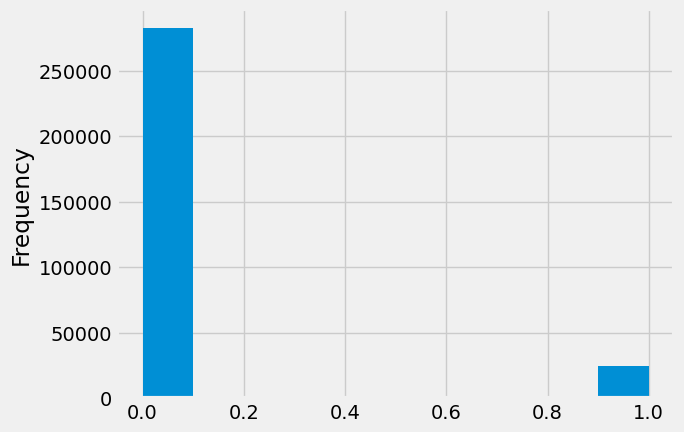

In [142]:
application_train['TARGET'].astype(int).plot.hist();

From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

## Missing Values

In [143]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [144]:
# Missing values statistics
missing_values = missing_values_table(application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


## Column Types

In [145]:
# Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [146]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encoding Categorical Variables

### Label Encoding and One-Hot Encoding

In [147]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [148]:
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

In [149]:
train_labels = application_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
application_train, app_test = application_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] = train_labels

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


### Anomalies

In [150]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [151]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

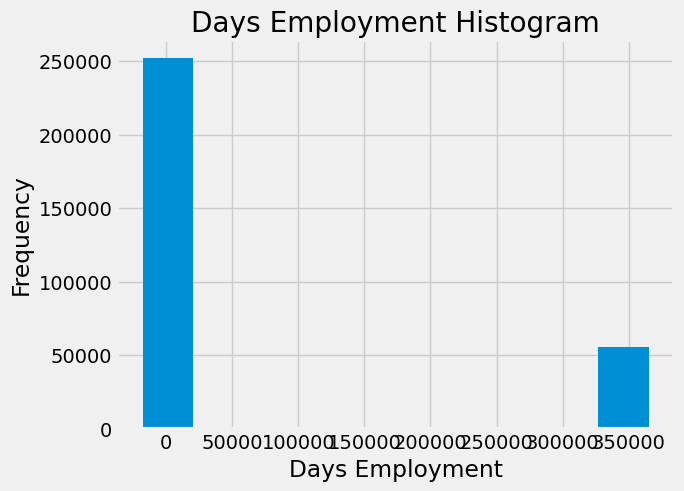

In [152]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [153]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


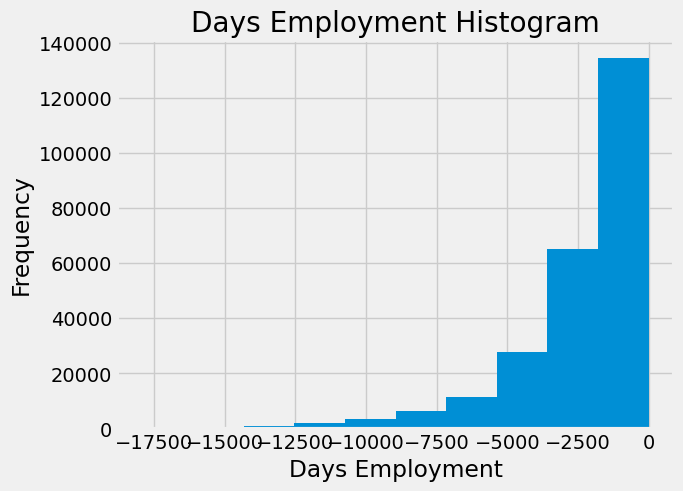

In [154]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [155]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

In [156]:
# Find correlations with the target and sort
correlations = application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

## Effect of Age on Repayment

In [157]:
# Find the correlation of the positive days since birth and target
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.07823930830982709

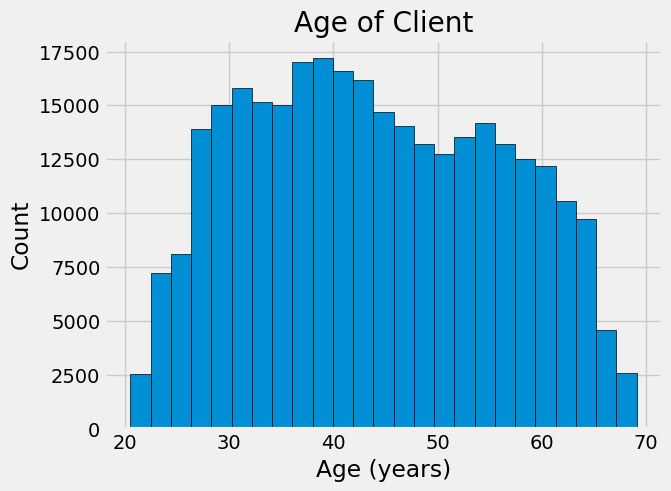

In [158]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

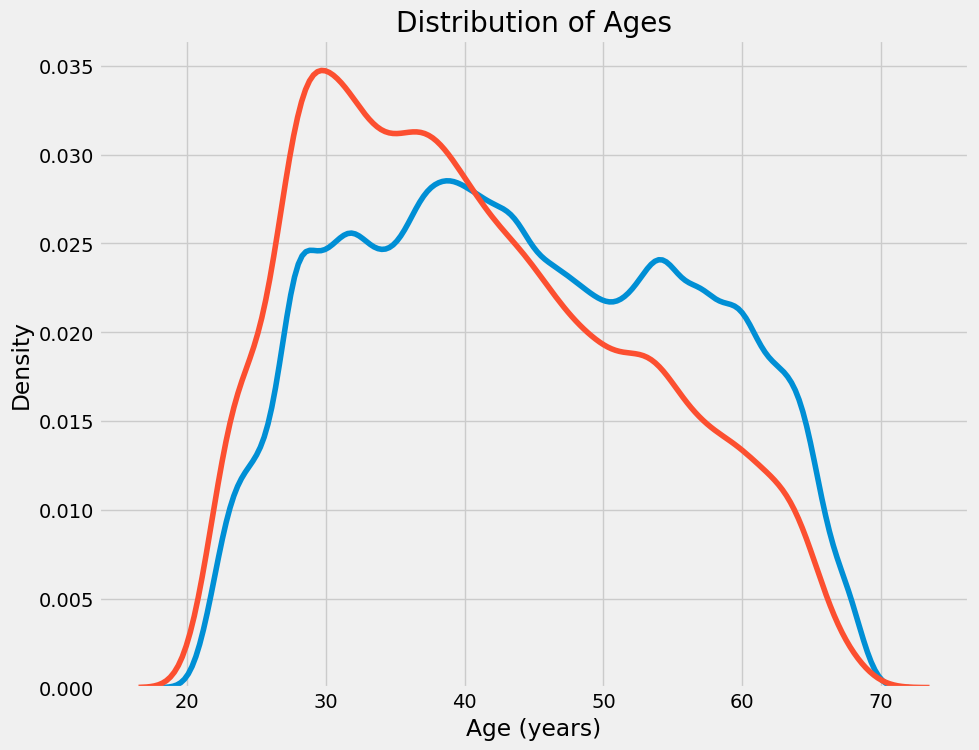

In [159]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [160]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [161]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


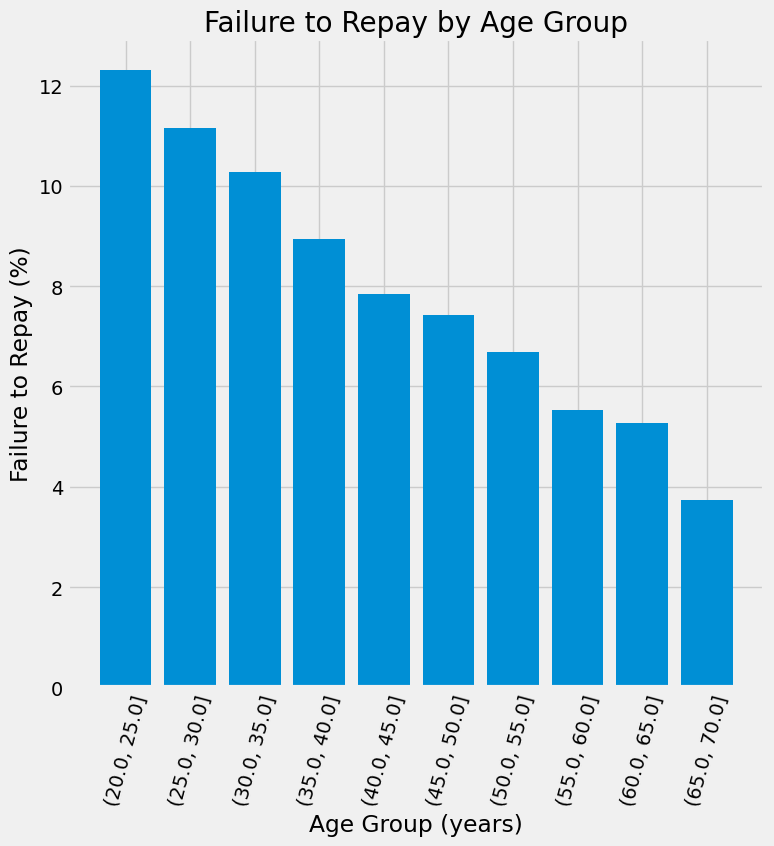

In [162]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Exterior Sources
The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [163]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


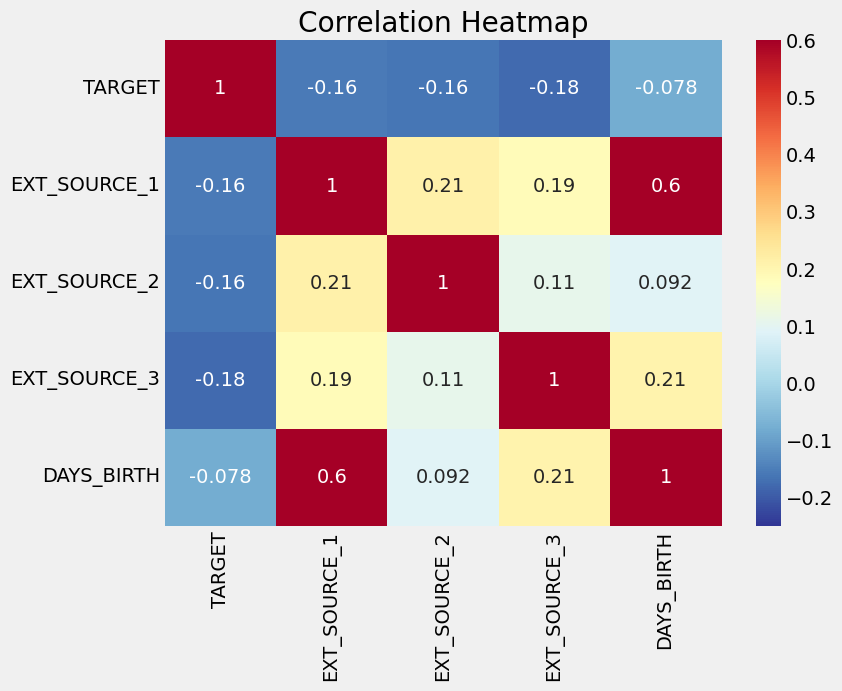

In [164]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

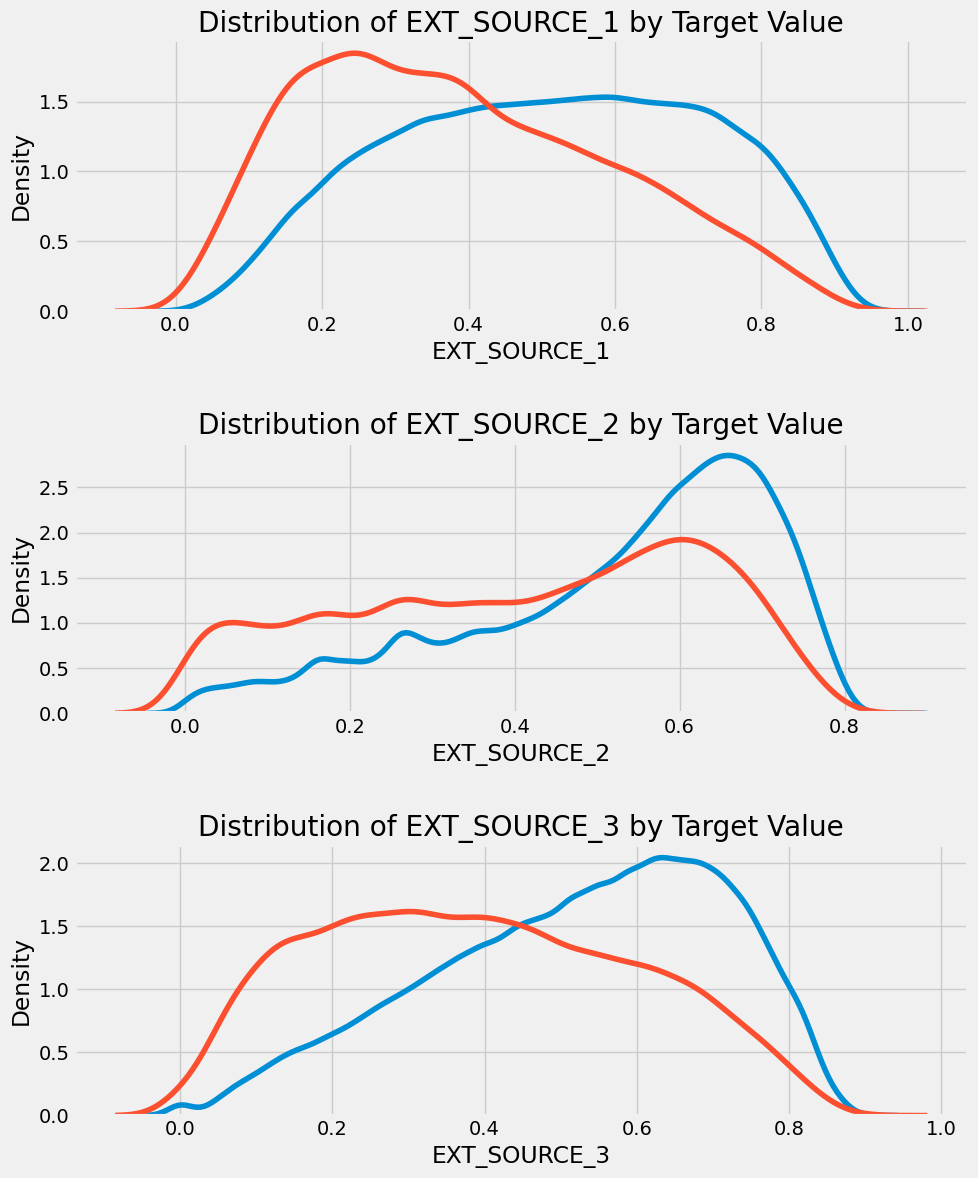

In [165]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

## Feature Engineering

In [166]:
import gc

In [167]:
# Label encoding for categorical columns with factorize
def label_encoder(df):
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    binary_categorical_columns = []
    for column in categorical_columns:
        if len(df[column].unique()) == 2:
            binary_categorical_columns.append(column)
    for bin_feature in binary_categorical_columns:
        df[bin_feature], uniques = pd.factorize(df[bin_feature], sort=True)
    return df

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [168]:
# Preprocess application_train.csv
def application_train(num_rows = None, nan_as_category = False):
    # Read data and merge
    df =pd.read_csv("donnée/application_train.csv")
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    df = label_encoder(df)
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df = df.set_index('SK_ID_CURR')
    gc.collect()
    return df
# Preprocess bureau.csv and bureau_balance.csv
def bureau_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv("donnée/bureau.csv")
   
    bb = pd.read_csv("donnée/bureau_balance.csv")
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg
# Preprocess POS_CASH_balance.csv
def POS_CASH_balance(num_rows = None, nan_as_category = True):
    pos =pd.read_csv("donnée/POS_CASH_balance.csv")
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts (POS_MONTHS_BALANCE_SIZE)
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv("donnée/installments_payments.csv")
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv("donnée/credit_card_balance.csv")
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [169]:
df_app_train = application_train()
df =df_app_train.copy()

In [170]:
df_app_train = application_train()
df_bureau_balance = bureau_balance()
df_pos_cash = POS_CASH_balance()
df_installments_payments = installments_payments()
df_credit_card_balance = credit_card_balance()

In [171]:
# taille des data frames 
df_app_train.shape, df_bureau_balance.shape, df_pos_cash.shape, df_installments_payments.shape, df_credit_card_balance.shape

((307507, 245), (305811, 116), (337252, 18), (339587, 26), (103558, 141))

In [172]:
# Join dataframes

df = df_app_train \
.join(df_bureau_balance, how='left', on='SK_ID_CURR') \
.join(df_pos_cash, how='left', on='SK_ID_CURR') \
.join(df_installments_payments, how='left', on='SK_ID_CURR') \
.join(df_credit_card_balance, how='left', on='SK_ID_CURR') \
.reset_index()

In [173]:
df.shape

(307507, 547)

In [174]:

# Drop duplicate rows and columns where too many Nan / Replace infini values by Nan values
def drop_columns_too_many_Nan(df): 
    df = df.drop_duplicates()
    total_nan_pourcentage = df.isnull().sum()/df.shape[0]
    features_inf = total_nan_pourcentage[total_nan_pourcentage.values<0.50]
    index_features_inf = list(features_inf.index)
    df_clean = df[index_features_inf]
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True) 
    return df_clean

df_final = drop_columns_too_many_Nan(df)

In [175]:
df_final.shape

(307507, 341)

In [176]:
df=df_final.copy()

In [177]:
# -- AMELIORATION DE L'USAGE DE LA MEMOIRE DES OBJETS
# --------------------------------------------------------------------

def reduce_mem_usage(data, verbose=True):
    # source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''

    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-' * 79)
        print('Memory usage du dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
        col_type = data[col].dtype

        #  Float et int
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(
                        np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if c_min > np.finfo(
                        np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

        # # Boolean : pas à faire car pour machine learning il faut des int 0/1
        # et pas False/True
        # if list(data[col].unique()) == [0, 1] or list(data[col].unique()) == [1, 0]:
        #     data[col] = data[col].astype(bool)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage après optimization: {:.2f} MB'.format(end_mem))
        print('Diminution de {:.1f}%'.format(
            100 * (start_mem - end_mem) / start_mem))
        print('-' * 79)

    return data


def convert_types(dataframe, print_info=False):

    original_memory = dataframe.memory_usage().sum()

    # Iterate through each column
    for c in dataframe:

        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            dataframe[c] = dataframe[c].fillna(0).astype(np.int32)

        # Convert objects to category
        elif (dataframe[c].dtype == 'object') and (dataframe[c].nunique() < dataframe.shape[0]):
            dataframe[c] = dataframe[c].astype('category')

        # Booleans mapped to integers
        elif list(dataframe[c].unique()) == [1, 0]:
            dataframe[c] = dataframe[c].astype(bool)

        # Float64 to float32
        elif dataframe[c].dtype == float:
            dataframe[c] = dataframe[c].astype(np.float32)

        # Int64 to int32
        elif dataframe[c].dtype == int:
            dataframe[c] = dataframe[c].astype(np.int32)

    new_memory = dataframe.memory_usage().sum()

    if print_info:
        print(
            f'Memory Usage à l\'origine : {round(original_memory / 1e9, 2)} Gb.')
        print(
            f'Memory Usage après modification des types: {round(new_memory / 1e9, 2)} Gb.')

    return dataframe


In [178]:
df =reduce_mem_usage(df, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 533.44 MB
Memory usage après optimization: 220.83 MB
Diminution de 58.6%
-------------------------------------------------------------------------------


In [179]:
# Export des données nettoyées 
df.to_csv('df_clean.csv',index=False)

# MODELISATION

In [180]:
# On se rassure que les noms des colonnes sont adéquats (sans espaces)
df.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").upper(),
                      df.columns))

df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [181]:
df.TARGET.value_counts()

0    282682
1     24825
Name: TARGET, dtype: int64

In [182]:
df.TARGET.value_counts()/df.shape[0]

0    0.91927
1    0.08073
Name: TARGET, dtype: float64

### Les données sont en grande partie déséquilibrées :

environ 92 % des données sont des clients à qui le prêt a été accordé (majorité classe 0)!!!!
Environ 8 % des données sont des clients ayant refusé le prêt-!!!!

## Normalization

In [183]:
target = df.TARGET
inputs = df.drop(columns=['TARGET','SK_ID_CURR'])
inputs_with_ids = df.drop(columns=['TARGET'])

In [184]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=42)

In [185]:
X_train.shape, X_test.shape

((246005, 339), (61502, 339))

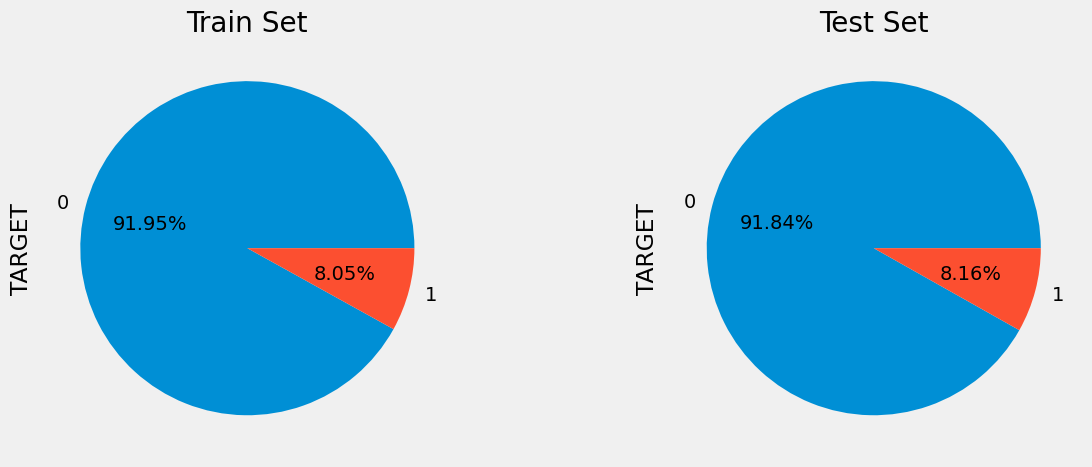

In [186]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(12,6))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set')
fig.subplots_adjust(wspace=0.5)

In [187]:
# On sauvegarde en csv les données test qui seront nos clients d'exemples pour API et dashboard
index_test = X_test.index.tolist()
X_test_with_id = inputs_with_ids.loc[index_test]
X_test_with_id.to_csv('data_test.csv',index=False)

## Preprocessing

Nous allons prétraiter les données en :

- remplissant les valeurs manquantes (imputation)
- normalisant les features (mise à l'échelle des features).

 ## Imputation des valeurs manquantes

In [188]:
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)

In [189]:
col_int = list(X_train.select_dtypes(include=['uint8', 'int64']).columns)
col_float = list(X_train.select_dtypes(include=['float64']).columns)
X_train_preprocess = X_train.copy()
X_test_preprocess = X_test.copy()

In [190]:
# Transform training data
# Fit on the training data
X_train[X_train==np.inf] = np.nan
imputer.fit(X_train)

X_test[X_test==np.inf] = np.nan

X_train_preprocess = imputer.transform(X_train)
X_test_preprocess = imputer.transform(X_test)

### Mise à l'échèle des valeurs

In [191]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
# Repeat with the scaler
scaler.fit(X_train_preprocess)
X_train_preprocess = scaler.transform(X_train_preprocess)
X_test_preprocess = scaler.transform(X_test_preprocess)
xtrain = pd.DataFrame(scaler.transform(X_train_preprocess), 
                      index=X_train.index, 
                      columns=X_train.columns)

xtest = pd.DataFrame(scaler.transform(X_test_preprocess), 
                     index=X_test.index, 
                     columns=X_test.columns)

**Stratégies de gestion du déséquilibre des données**


- L'analyse exploratoire a permis de mettre en lumière le Le caractère **déséquilibré** du jeu de données : 91,93% des prêts ont été remboursés, contre seulement 8,07% de prêts non remboursés dans le jeu de données.




On va utiliser 3 approches et comparer les résultats pour l'ensemble des modèles.

   - **Undersampling** : supprimer des observations de la classe majoritaire afin de rééquilibrer le jeu de données
   - **Oversampling** : répéter des observations de la classe minoritaire afin de rééquilibrer le jeu de données
   - **Weight_balanced** : indiquer au modèle le déséquilibre afin qu'il en tienne compte directement


In [192]:
#pip install imbalanced-learn

In [193]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [194]:
results = pd.DataFrame(columns=["Algorithm", "Balancing_method", "AUC", "AUC_test","Time"])

In [195]:
#------------------------------------------
# MODELISATION
#------------------------------------------

def evaluate_model(gs, x, y, x_test, y_test, model_name, balancing_method):
    
    #Entrainement
    start = time.time()
    model = gs.fit(x,y)
    end = time.time()-start

    if (model_name != 'Baseline'):
        df_results = pd.DataFrame.from_dict(model.cv_results_)

    #Training Performance
    if (model_name == 'Baseline'):
        
        y_proba = model.predict_proba(x)

        auc_train = round(roc_auc_score(y, y_proba[:,1]),3) 
        
    else:
        auc_train = round(model.best_score_,3) 
        

    #Testing Performance
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)
    auc_test = round(roc_auc_score(y_test, y_proba[:,1]),3) 
   
    

    row = [model_name, 
            balancing_method,
            auc_train, 
            auc_test,
            end]

    return row 


In [196]:
#Undersampling
rus = RandomUnderSampler(random_state=42,sampling_strategy=0.4)
xtrain_us, ytrain_us = rus.fit_resample(xtrain , y_train)


In [197]:
#Oversampling
smote = SMOTE(random_state=42,sampling_strategy=0.4)
xtrain_os, ytrain_os = smote.fit_resample(xtrain , y_train)

In [198]:
def reduce_mem_usage(data, verbose=True):

    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-' * 79)
        print('Memory usage du dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
        col_type = data[col].dtype

        #  Float et int
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(
                        np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if c_min > np.finfo(
                        np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage après optimization: {:.2f} MB'.format(end_mem))
        print('Diminution de {:.1f}%'.format(
            100 * (start_mem - end_mem) / start_mem))
        print('-' * 79)

    return data


def convert_types(dataframe, print_info=False):

    original_memory = dataframe.memory_usage().sum()

    # Iterate through each column
    for c in dataframe:

        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            dataframe[c] = dataframe[c].fillna(0).astype(np.int32)

        # Convert objects to category
        elif (dataframe[c].dtype == 'object') and (dataframe[c].nunique() < dataframe.shape[0]):
            dataframe[c] = dataframe[c].astype('category')

        # Booleans mapped to integers
        elif list(dataframe[c].unique()) == [1, 0]:
            dataframe[c] = dataframe[c].astype(bool)

        # Float64 to float32
        elif dataframe[c].dtype == float:
            dataframe[c] = dataframe[c].astype(np.float32)

        # Int64 to int32
        elif dataframe[c].dtype == int:
            dataframe[c] = dataframe[c].astype(np.int32)

    new_memory = dataframe.memory_usage().sum()

    if print_info:
        print(
            f'Memory Usage à l\'origine : {round(original_memory / 1e9, 2)} Gb.')
        print(
            f'Memory Usage après modification des types: {round(new_memory / 1e9, 2)} Gb.')

    return dataframe


#### DummyClassifier (Baseline)

#### Under Sampling

In [199]:
dc1 = DummyClassifier(strategy="most_frequent")
dc2 = DummyClassifier(strategy="stratified")

In [200]:
row = evaluate_model(dc1, xtrain_us, ytrain_us,xtest, y_test, \
                        "Baseline", "Undersampling")


In [201]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.5,0.5,0.009974


#### Oversampling (Using SMOTE)

In [202]:
row = evaluate_model(dc1, xtrain_os, ytrain_os, xtest, y_test,\
                        "Baseline", "Oversampling")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.5,0.5,0.009974
1,Baseline,Oversampling,0.5,0.5,0.029921


### class_weight='balanced'

In [203]:
row = evaluate_model(dc2,xtrain,y_train, xtest, y_test, \
                        "Baseline", "Balanced")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977


### LGBMClassifier

In [204]:
lgbm = LGBMClassifier(random_state = 42, objective = 'binary')

lgbm_balanced = LGBMClassifier(random_state = 42,
                                   objective = 'binary',
                                   class_weight = 'balanced')

In [205]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05]
}

gs_lgbm = GridSearchCV(
    lgbm,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_lgbm_balanced = GridSearchCV(
    lgbm_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

#### Under Sampling

In [206]:
row = evaluate_model(gs_lgbm,xtrain_us, ytrain_us, xtest, y_test, \
                        "LGBM", "Undersampling")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435


#### Oversampling 

In [207]:
model = imbPipeline([
        ('sampling', SMOTE()),
        ('clf', LGBMClassifier(random_state = 42, objective = 'binary'))
    ])

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.05]
}

gs_lgbm_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [208]:
row = evaluate_model(gs_lgbm_os,xtrain_os, ytrain_os, xtest, y_test,\
                        "LGBM", "Oversampling")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435
4,LGBM,Oversampling,0.758,0.757,872.556676


### class_weight='balanced'

In [209]:
row =evaluate_model(gs_lgbm_balanced,xtrain, y_train, xtest, y_test, \
                        "LGBM", "Balanced")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435
4,LGBM,Oversampling,0.758,0.757,872.556676
5,LGBM,Balanced,0.774,0.773,274.909288


### Régression Logistique 

In [210]:
lr = LogisticRegression()
lr_balanced = LogisticRegression(class_weight="balanced")

In [211]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr = GridSearchCV(
    lr,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_lr_balanced = GridSearchCV(
    lr_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

#### Under Sampling

In [212]:
row = evaluate_model(gs_lr, xtrain_us, ytrain_us, xtest, y_test, \
                        "LogisticRegression", "Undersampling")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435
4,LGBM,Oversampling,0.758,0.757,872.556676
5,LGBM,Balanced,0.774,0.773,274.909288
6,LogisticRegression,Undersampling,0.740,0.740,101.203029


#### Oversampling 

In [213]:
model = imbPipeline([
        ('sampling', SMOTE()),
        ('clf', LogisticRegression())
    ])

params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [214]:
row = evaluate_model(gs_lr_os, xtrain_os, ytrain_os, xtest, y_test, \
                        "LogisticRegression", "Oversampling")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435
4,LGBM,Oversampling,0.758,0.757,872.556676
5,LGBM,Balanced,0.774,0.773,274.909288
6,LogisticRegression,Undersampling,0.740,0.740,101.203029
7,LogisticRegression,Oversampling,0.728,0.730,1787.821095


#### Balanced

In [215]:
row = evaluate_model(gs_lr_balanced,xtrain, y_train, xtest, y_test, \
                        "LogisticRegression", "Balanced")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435
4,LGBM,Oversampling,0.758,0.757,872.556676
5,LGBM,Balanced,0.774,0.773,274.909288
6,LogisticRegression,Undersampling,0.740,0.740,101.203029
7,LogisticRegression,Oversampling,0.728,0.730,1787.821095
8,LogisticRegression,Balanced,0.738,0.739,319.770162


### RandomForestClassifier

In [216]:
rf = RandomForestClassifier(random_state = 42)

rf_balanced = RandomForestClassifier(random_state = 42, 
                                     class_weight="balanced")

In [217]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}

gs_rf = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_rf_balanced = GridSearchCV(
    rf_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

#### Under Sampling

In [218]:
row = evaluate_model(gs_rf,xtrain_us, ytrain_us, xtest, y_test,"RandomForest", "Undersampling")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435
4,LGBM,Oversampling,0.758,0.757,872.556676
5,LGBM,Balanced,0.774,0.773,274.909288
6,LogisticRegression,Undersampling,0.740,0.740,101.203029
7,LogisticRegression,Oversampling,0.728,0.730,1787.821095
8,LogisticRegression,Balanced,0.738,0.739,319.770162
9,RandomForest,Undersampling,0.739,0.738,151.409511


#### Oversampling 

In [219]:
model =imbPipeline([
        ('sampling', SMOTE()),
        ('clf', RandomForestClassifier(random_state = 42))
    ])

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [5, 10]
}

gs_rf_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [220]:
row = evaluate_model(gs_rf_os,xtrain_os, ytrain_os, xtest, y_test, \
                        "RandomForest", "Oversampling")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435
4,LGBM,Oversampling,0.758,0.757,872.556676
5,LGBM,Balanced,0.774,0.773,274.909288
6,LogisticRegression,Undersampling,0.740,0.740,101.203029
7,LogisticRegression,Oversampling,0.728,0.730,1787.821095
8,LogisticRegression,Balanced,0.738,0.739,319.770162
9,RandomForest,Undersampling,0.739,0.738,151.409511


### class_weight='balanced'

In [221]:
row = evaluate_model(gs_rf_balanced ,xtrain, y_train, xtest, y_test, \
                        "RandomForest", "Balanced")
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.009974
1,Baseline,Oversampling,0.500,0.500,0.029921
2,Baseline,Balanced,0.499,0.501,0.007977
3,LGBM,Undersampling,0.773,0.771,88.910435
4,LGBM,Oversampling,0.758,0.757,872.556676
5,LGBM,Balanced,0.774,0.773,274.909288
6,LogisticRegression,Undersampling,0.740,0.740,101.203029
7,LogisticRegression,Oversampling,0.728,0.730,1787.821095
8,LogisticRegression,Balanced,0.738,0.739,319.770162
9,RandomForest,Undersampling,0.739,0.738,151.409511


In [222]:
def plotComparaisonResults(metrics_compare, metric):
    
    fig, ax = plt.subplots()
    
    # create data
    x = np.arange(4)
    y1 = metrics_compare [metrics_compare['Balancing_method'] == "Undersampling"] [metric]
    y2 = metrics_compare [metrics_compare['Balancing_method'] == "Oversampling"] [metric]
    y3 = metrics_compare [metrics_compare['Balancing_method'] == "Balanced"] [metric]
    width = 0.2

    # plot data in grouped manner of bar type
    b1 = plt.bar(x-0.2, y1, width)
    b2 = plt.bar(x, y2, width)
    b3 = plt.bar(x+0.2, y3, width)
    plt.xticks(x, ['DumCla(Baseline)', 'LGBM', 'RégLog','RanFor'])
    

    if (metric =="AUC"):
        plt.title('AUC des modèles (train)')
    
    if(metric =="AUC_test"):
        plt.title('AUC des modèles (test)')
        
    if (metric =="Time"):
        plt.ylabel("Time (sec)")
        plt.title("Temps d'exécution du fit")    
    else:
        plt.ylabel("AUC score")
    plt.legend(["Undersampling", "Oversampling", "Balanced"], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

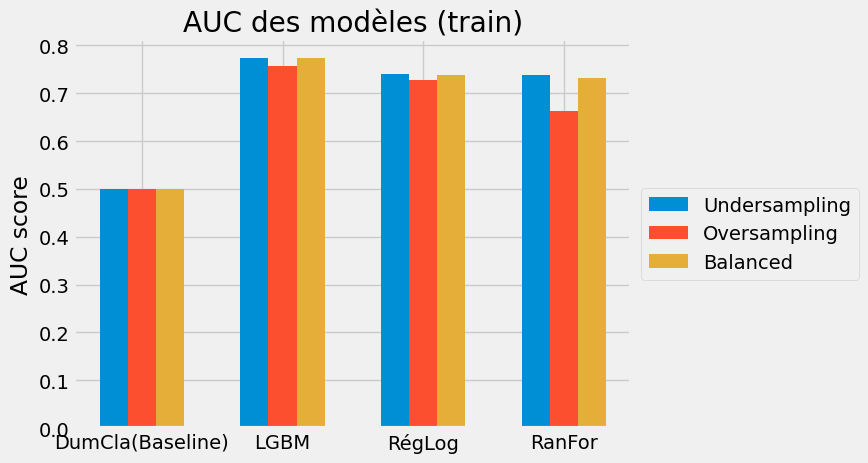

In [223]:
plotComparaisonResults(results, 'AUC')

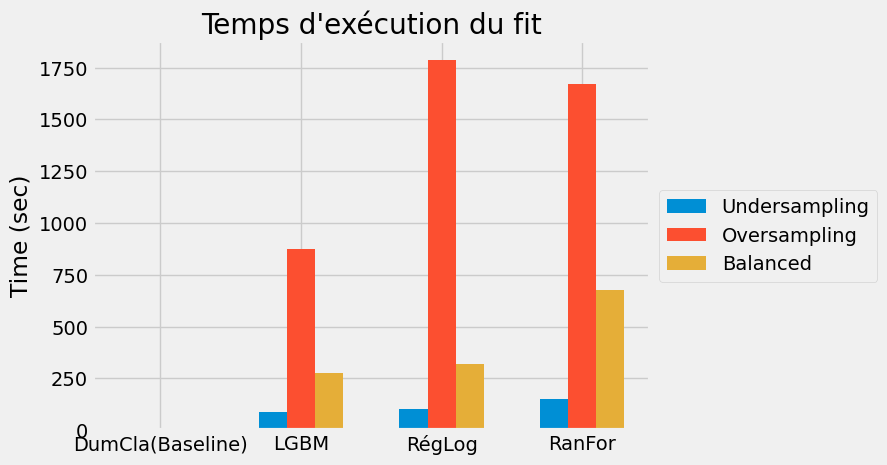

In [224]:
plotComparaisonResults(results, 'Time')

### Modèle sélectionné ; Light Gradient Boosting

# Fonction coût, algorithme d’optimisation et métrique d’évaluation

### Confussion Matrix Avec ROC_OUC

In [257]:
def conf_matrix_avec_roc_auc(model, y_true, y_pred, y_pred_proba, roc_auc, title):

    fig = plt.figure(figsize=(18,12))
  
    plt.subplot(221)
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['TN', 'FP', 'FN', 'TP']
    
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.legend()

    fig.suptitle(title, fontsize="30", fontweight="bold")
    plt.show()
    

In [258]:
y_proba = gs_lgbm.predict_proba(xtest)

In [259]:
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)

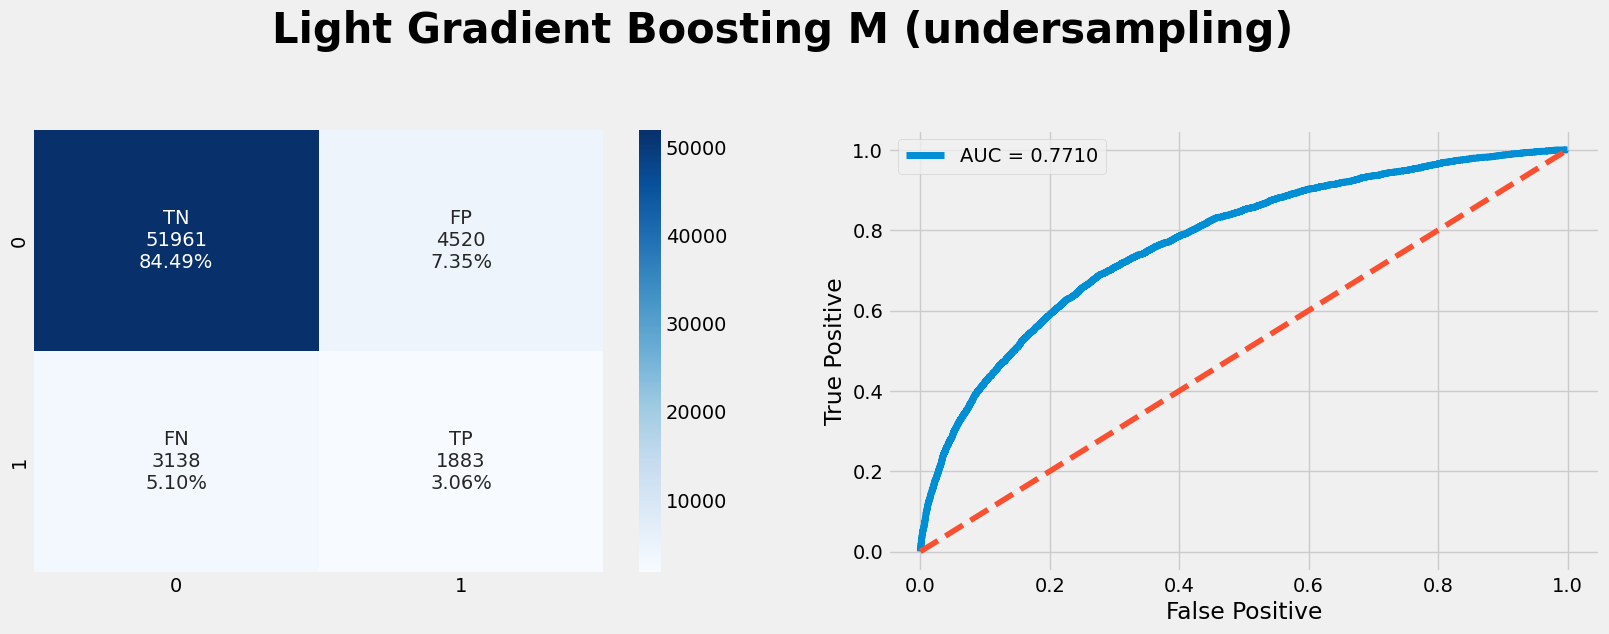

In [273]:
conf_matrix_avec_roc_auc(gs_lgbm, y_test, gs_lgbm.predict(xtest),\
                         gs_lgbm.predict_proba(xtest)[:,1], roc_auc,"Light Gradient Boosting M (undersampling) ")

## Fonction de coût métier

#### Optimisation du modèle d’un point de vue métier

- TN = 1
- FP = 0
- FN = -10
- TP = 0

In [261]:
def score_de_credit(y_true, y_pred, FN=-10, FP=0, TP=0,TN=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
     
    tn = mat_conf[0, 0]
    fn = mat_conf[1, 0]
    fp = mat_conf[0, 1]
    tp = mat_conf[1, 1]
    
    # Gain total
    gain  = tp*TP + tn*TN + fp*FP + fn*FN
    
    # Gain maximum
    max_gain  = (fp + tn)*TN + (fn + tp)*TP
    
    # Gain minimum
    min_gain  = (fp + tn)*FP + (fn + tp)*FN
    
    # Gain normalisé entre 0 et 1
    gain_normalized = ( gain  - min_gain )/(max_gain - min_gain )
    
    return gain_normalized   # Retourne la fonction d'évaluation

In [268]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 800, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 10),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20),
    'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
}

def objective(params, eval_metric='score_de_credit'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model,  xtrain_us, ytrain_us, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'score_de_credit': 
        y_pred = cross_val_predict(model,  xtrain_us, ytrain_us, method='predict', cv=cv)
        score = score_de_credit( ytrain_us, y_pred)
    elif eval_metric == 'F1':
        model.fit( xtrain_us, ytrain_us)
        y_pred = model.predict( xtest)
        score = fbeta_score(y_test, y_pred, beta=1)

  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


In [272]:
MEILLEUR = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|████████████████████████████████████████████████| 10/10 [05:39<00:00, 33.99s/trial, best loss: 0.5126641082609573]


In [274]:
MEILLEUR

{'colsample_bytree': 0.869998313358616,
 'learning_rate': 0.02489875305494689,
 'max_depth': 10.0,
 'n_estimators': 700.0,
 'reg_lambda': 17.983970841843025,
 'solvability_threshold': 0.5,
 'subsample': 0.7764641513829338}

## Le meilleur seuil de solvabilité est de 0.5

In [276]:
lgbm_V2 = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(MEILLEUR['n_estimators']), 
    colsample_bytree= MEILLEUR['colsample_bytree'],
    learning_rate= MEILLEUR['learning_rate'],
    max_depth= int(MEILLEUR['max_depth']),
    subsample= MEILLEUR['subsample'],
    reg_lambda= MEILLEUR['reg_lambda'],
    )

lgbm_V2.fit(xtrain_us, ytrain_us)

LGBMClassifier(colsample_bytree=0.869998313358616,
               learning_rate=0.02489875305494689, max_depth=10,
               n_estimators=700, reg_lambda=17.983970841843025,
               subsample=0.7764641513829338)

In [287]:
feature_importance_values = LGBMClassifier.feature_importances_


In [277]:
roc_auc = roc_auc_score(y_test, lgbm_V2.predict_proba(xtest)[:,1])
print('AUC : %0.4f' %roc_auc)

AUC : 0.7755


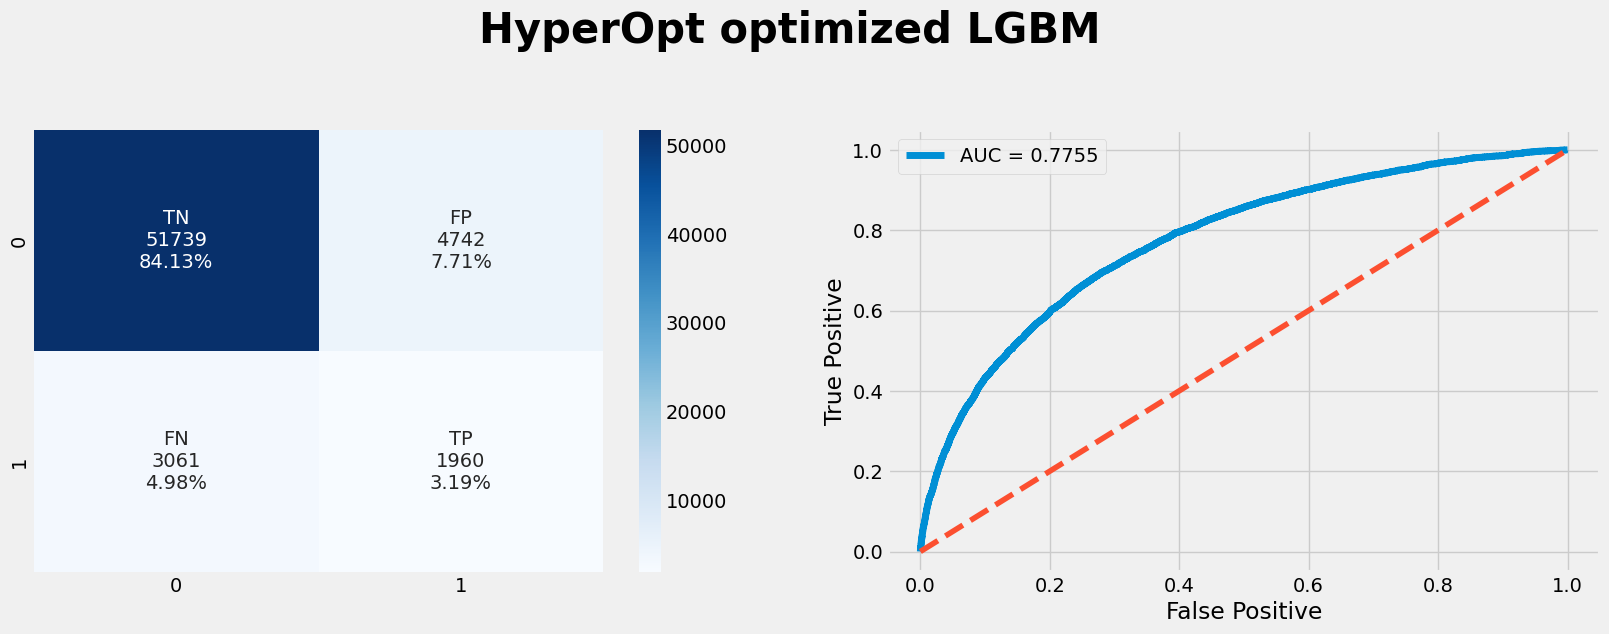

In [278]:
conf_matrix_avec_roc_auc(lgbm_V2, y_test, lgbm_V2.predict(xtest), lgbm_V2.predict_proba(xtest)[:,1],roc_auc, "HyperOpt optimized LGBM")

**Evolution du gain en fonction du seuil de solvabilité**

In [282]:
def gain_seuil(clf, y_set, x_set):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 20)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(score_de_credit(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

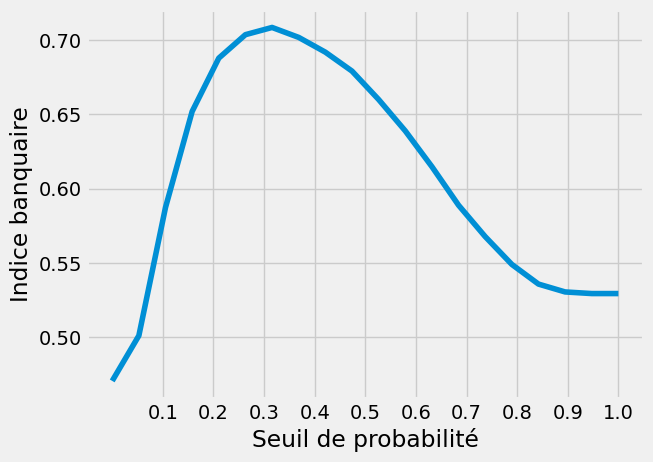

In [283]:
# Affiche le meilleur seuil de probabilité
gain_seuil(lgbm_V2, y_test, xtest)

### Interprétabilité du modèle : Feature Importances

In [291]:
# Initialisation de la matrice de l'importance des variables 
feature_importance_values = np.zeros(len(xtest.columns.tolist()))
feature_importance_values = lgbm_V2.feature_importances_

# Dataframe de l'importance des variables
feat_imp = pd.DataFrame({'feature': xtest.columns.tolist(), 'importance': feature_importance_values})

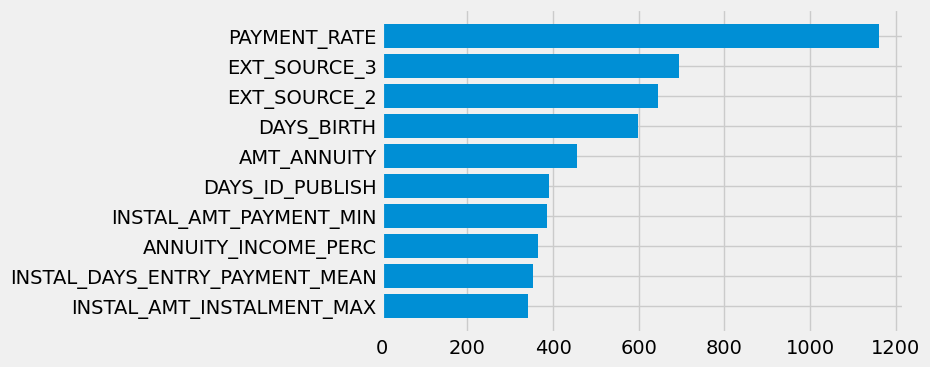

In [293]:
x = feature_importances_top.sort_values('importance')['feature']
y = feature_importances_top.sort_values('importance')['importance']

plt.figure(figsize=(6,4))
plt.barh(x, y)
plt.show()

### SHAP

In [294]:
X_importance =xtest
explainer = shap.TreeExplainer(lgbm_V2)
shap_values = explainer.shap_values(X_importance)

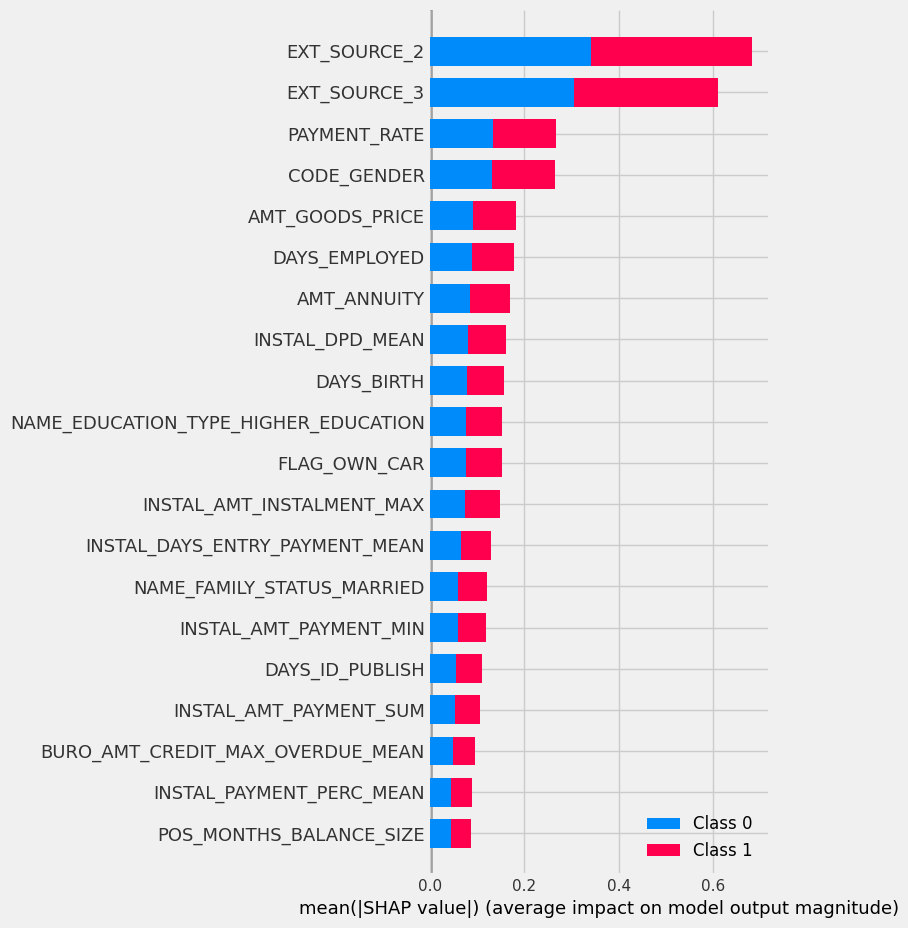

In [295]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

In [298]:
#Sauvegarde du modèle au formate pkl
pickle.dump( lgbm_V2, open("./LGBMClassifier.pkl", "wb"))

In [ ]:
joblib.dump(lgbm_V2, 'LGBMClassifier.pkl') 

In [1]:
import joblib

In [300]:
application_train = pd.read_csv("../P7/Donnée/application_train.csv")
application_test = pd.read_csv("../P7/Donnée/application_test.csv")

In [ ]:
application_train.to_parquet('application_train.parquet')
application_test.to_parquet('application_test.parquet')